In [1]:
import os
import sys
from collections import Counter

import matplotlib
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import PIL
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
from sklearn.metrics import ConfusionMatrixDisplay, confusion_matrix
from torch.utils.data import DataLoader, random_split
from torchinfo import summary
from torchvision import datasets, transforms
from tqdm.notebook import tqdm

torch.backends.cudnn.deterministic = True

In [2]:
print("Platform:", sys.platform)
print("Python version:", sys.version)
print("---")
print("matplotlib version:", matplotlib.__version__)
print("pandas version:", pd.__version__)
print("PIL version:", PIL.__version__)
print("torch version:", torch.__version__)
print("torchvision version:", torchvision.__version__)

Platform: win32
Python version: 3.13.2 | packaged by Anaconda, Inc. | (main, Feb  6 2025, 18:49:14) [MSC v.1929 64 bit (AMD64)]
---
matplotlib version: 3.10.0
pandas version: 2.2.3
PIL version: 11.1.0
torch version: 2.7.0+cpu
torchvision version: 0.22.0+cpu


In [3]:
if torch.cuda.is_available():
    device = "cuda"
elif torch.backends.mps.is_available():
    device = "mps"
else:
    device = "cpu"

print(f"Using {device} device.")

Using cpu device.


In [4]:
class ConvertToRGB:
    def __call__(self, img):
        if img.mode != "RGB":
            img = img.convert("RGB")
        return img

In [5]:
transform = transforms.Compose(
    [
        ConvertToRGB(),
        transforms.Resize((224, 224)),
        transforms.ToTensor(),
    ]
)

In [6]:
data_dir = 'datamulticlass/'
train_dir = os.path.join(data_dir, "train_sorted")

print("Will read data from", train_dir)

Will read data from datamulticlass/train_sorted


In [7]:
dataset = datasets.ImageFolder(root = train_dir, transform = transform)

In [8]:
print("Classes:")
print(dataset.classes)
print(f"That's {len(dataset.classes)} classes")
print()
print("Tensor shape for one image:")
print(dataset[0][0].shape)

Classes:
['antelope_duiker', 'bird', 'blank', 'civet_genet', 'hog', 'leopard', 'monkey_prosimian', 'rodent']
That's 8 classes

Tensor shape for one image:
torch.Size([3, 224, 224])


In [9]:
batch_size = 32
dataset_loader = DataLoader(dataset, batch_size=batch_size)

# Get one batch
first_batch = next(iter(dataset_loader))

print(f"Shape of one batch: {first_batch[0].shape}")
print(f"Shape of labels: {first_batch[1].shape}")

Shape of one batch: torch.Size([32, 3, 224, 224])
Shape of labels: torch.Size([32])


# channel statistics extraction(Normalization of our data)

In [10]:
def get_mean_std(loader):
    """Computes the mean and standard deviation of image data.

    Input: a `DataLoader` producing tensors of shape [batch_size, channels, pixels_x, pixels_y]
    Output: the mean of each channel as a tensor, the standard deviation of each channel as a tensor
            formatted as a tuple (means[channels], std[channels])"""

    channels_sum, channels_squared_sum, num_batches = 0, 0, 0
    for data, _ in tqdm(loader, desc="Computing mean and std", leave=False):
        channels_sum += torch.mean(data, dim=[0, 2, 3])
        channels_squared_sum += torch.mean(data**2, dim=[0, 2, 3])
        num_batches += 1
    mean = channels_sum / num_batches
    std = (channels_squared_sum / num_batches - mean**2) ** 0.5

    return mean, std

In [11]:
mean, std = get_mean_std(dataset_loader)

print(f"Mean: {mean}")
print(f"Standard deviation: {std}")

Computing mean and std:   0%|          | 0/516 [00:00<?, ?it/s]

Mean: tensor([0.4788, 0.4925, 0.4834])
Standard deviation: tensor([0.2541, 0.2471, 0.2501])


Now that we have these values, we can adjust our pixels. To get mean 
, we need to subtract our measured mean from every pixel. To get standard deviation 
, we divide every pixel by the std.

We can perform these calculations using the Normalize transformation that torchvision gives us. We'll add it as an extra step to the transform we created earlier. Since we're doing the three color channels separately, we'll nave to give Normalize a vector with three means (and the same for standard deviation). Conveniently, that's what we have.

In [12]:
transform_norm = transforms.Compose(
    [
        ConvertToRGB(),
        transforms.Resize((224, 224)),
        transforms.ToTensor(),
        transforms.Normalize(mean=mean, std=std),
    ]
)

# Make a new normalized dataset using ImageFolder and a new DataLoader

In [13]:
norm_dataset = datasets.ImageFolder(root=train_dir, transform=transform_norm)

norm_loader = DataLoader(dataset=norm_dataset, batch_size=32)

# Use the get_mean_std function to verify the mean and standard deviation are correct in the norm_loader data

In [14]:
norm_mean, norm_std = get_mean_std(norm_loader)

print(f"Mean: {norm_mean}")
print(f"Standard deviation: {norm_std}")

Computing mean and std:   0%|          | 0/516 [00:00<?, ?it/s]

Mean: tensor([ 3.1621e-07, -2.9477e-07,  7.2351e-07])
Standard deviation: tensor([1.0000, 1.0000, 1.0000])


The means may not be exactly zero due to machine precision. But they should be extremely small.

# Train and validation splitting

Use random_split to create a training dataset with 80% of the data, and a validation dataset with 20% of the data. Be sure to use the normalized data.

In [15]:
# Important, don't change this!
g = torch.Generator()
g.manual_seed(42)

train_dataset, val_dataset = random_split(norm_dataset, [0.8, 0.2])

length_train = len(train_dataset)
length_val = len(val_dataset)
length_dataset = len(norm_dataset)
percent_train = np.round(100 * length_train / length_dataset, 2)
percent_val = np.round(100 * length_val / length_dataset, 2)

print(f"Train data is {percent_train}% of full data")
print(f"Validation data is {percent_val}% of full data")

Train data is 80.0% of full data
Validation data is 20.0% of full data


We want the training data and validation data to be similar. Ideally, the random split should do that for us. But with multiple categories, it's possible we have too much of one category ending up in training or validation. For example, we could have gotten really unlucky and wound up with all of our leopards in the validation set.

We should check how many of each category we have in each of our data sets. We aren't expecting the same number of each. The different categories started with different amounts, and the training set is 
 times as big. But we should expect the training and validation sets to have the same proportion of each category.

As we did in the last notebook, we can visualize this with a bar chart. We'll use the same function as last time.

# BarPlot Replication

In [16]:
def class_counts(dataset):
    c = Counter(x[1] for x in tqdm(dataset))
    class_to_index = dataset.dataset.class_to_idx
    return pd.Series({cat: c[idx] for cat, idx in class_to_index.items()})

We can use it to see how many of each category in our training dataset.

In [17]:
train_class_distributions = class_counts(train_dataset)

train_class_distributions

  0%|          | 0/13191 [00:00<?, ?it/s]

antelope_duiker     1982
bird                1291
blank               1773
civet_genet         1941
hog                  771
leopard             1799
monkey_prosimian    2006
rodent              1628
dtype: int64

# Create a bar plot from these counts. 

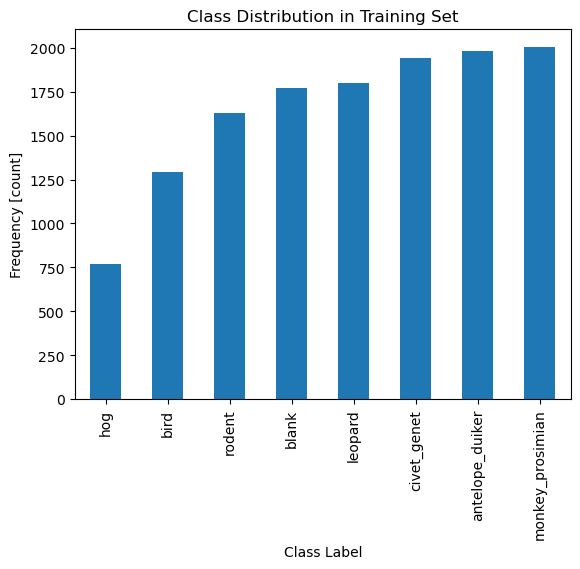

In [18]:
# Create a bar plot from train_class_distribution
train_class_distributions.sort_values().plot(kind="bar")

# Add axis labels and title
plt.xlabel("Class Label")
plt.ylabel("Frequency [count]")
plt.title("Class Distribution in Training Set");

  0%|          | 0/3297 [00:00<?, ?it/s]

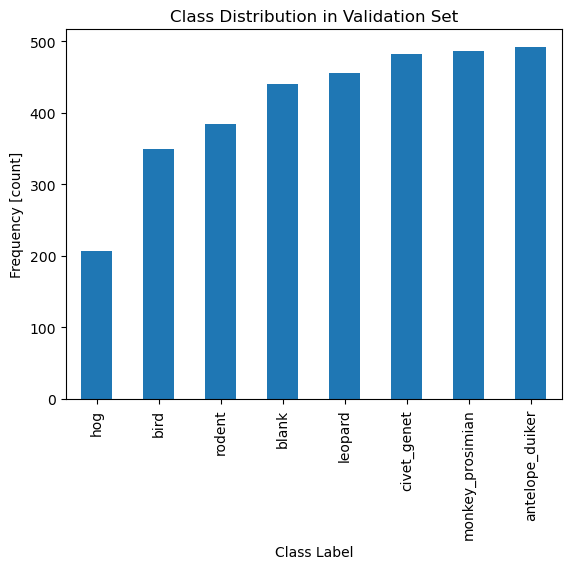

In [19]:
# Get the class distribution
validation_class_distributions = class_counts(val_dataset)

# Create a bar plot from train_class_distribution
validation_class_distributions.sort_values().plot(kind="bar")

# Add axis labels and title
plt.xlabel("Class Label")
plt.ylabel("Frequency [count]")
plt.title("Class Distribution in Validation Set");

 Create data loaders for the train and validation sets. Use a batch size of  Be sure to turn on shuffling for the training set.

In [20]:
# Important, don't change this!
g = torch.Generator()
g.manual_seed(42)


batch_size = 32

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

val_loader = DataLoader(val_dataset, batch_size=batch_size)

single_batch = next(iter(train_loader))[0]
print(f"Shape of one batch: {single_batch.shape}")

Shape of one batch: torch.Size([32, 3, 224, 224])


# Predictive Class Selection

In [21]:
sample_confidence = torch.tensor([0.13, 0.01, 0.02, 0.12, 0.10, 0.34, 0.16, 0.12])

In [22]:
norm_dataset.classes

['antelope_duiker',
 'bird',
 'blank',
 'civet_genet',
 'hog',
 'leopard',
 'monkey_prosimian',
 'rodent']

In [23]:
torch.argmax(sample_confidence)

tensor(5)

In [24]:
classes = norm_dataset.classes

class_number = torch.argmax(sample_confidence)
prediction = classes[class_number]

print(f"This image is a {prediction}")

This image is a leopard


# Network Architecture

Now we need a model. We'll build another neural network. The one we built last time was a shallow neural network. This is a network made of a sequence of "dense" or "fully connected" layers. But that's not the only option! You can connect the neurons in different ways, to get different _architectures_.

The shallow neural network is the "standard", most common one. We could use it for our problem, but to get good accuracy we'd need to add more layers. That network would take a long time to train. We'll be better served by using an architecture meant for images. 

A good option, and the one we'll use, is the convolutional neural network (CNN). It consists of a sequence of convolutional and max pooling layers. These are usually followed by some fully connected layers and an output layer.

# Convolution and Max Pooling Layers

The CNN gets its name from the convolutional layers. These layers take in an image, maintaining the 2D structure, and convolve it with a number of kernels. Each kernel will produce a new image. Thankfully, PyTorch will do all the math and tracking for us. Just like we had Linear layers before, we can get a convolutional layer by adding a Conv2D to our model.

As before, we'll use a Sequential model to keep track of how to build things.

In [25]:
model_seq = torch.nn.Sequential()

To create a convolution layer, we need to provide it with three arguments: the number of channels it expects as input, the number of kernels to create, and the size of those kernels. We don't have to specify the size of the images, it'll figure that out. 

This first layer will be looking at our input images. They have three color channels, so we set `in_channels=3`. For our kernels, let's start with $16$ kernels of size $3$ x $3$. We specify the kernel size with `kernel_size=(3,3)`, and the number of kernels with `out_channels=16`. We'll also need padding to keep our image size. With a $3$ x $3$ kernel, we'll set padding to $1$.

In [26]:
conv1 = torch.nn.Conv2d(in_channels=3, out_channels=16, kernel_size=(3, 3), padding=1)
model_seq.append(conv1)

Sequential(
  (0): Conv2d(3, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
)


Let's also get a single batch of 
 images, so we can see what the model is doing.

In [27]:
test_batch = next(iter(train_loader))[0]

Let's make sure the batch is the shape we expect. It should be 
 images, with 
 color channels, of size 
 x 
.

# Get the shape of the batch and store it to batch_shape.

In [28]:
batch_shape = test_batch.shape

print(f"Batch shape: {batch_shape}")

Batch shape: torch.Size([32, 3, 224, 224])


Now we can run the model we have so far on the data. Since we only have the one convolutional layer, we'll see its output.

This is a useful trick for making sure we're getting what we expect. What do we expect here? We should still have 
 images, but now they should have 
 channels corresponding to the 
 kernels.

# output shape capture

In [29]:
first_step_out = model_seq(test_batch)

In [30]:
first_step_shape = first_step_out.shape

print(f"Shape after first convolution layer: {first_step_shape}")

Shape after first convolution layer: torch.Size([32, 16, 224, 224])


As always with a network, we'll need an activation function. Here we'll use the ReLU like we did in the previous notebook.

In [31]:
model_seq.append(torch.nn.ReLU())

Sequential(
  (0): Conv2d(3, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (1): ReLU()
)

Our convolution layers transform images into more images. Ultimately, we're going to need to get down to just our 
 output classes. But our convolution has increased the number of pixels! Max pooling will let us shrink our image.

In PyTorch, this is a MaxPool2D layer. The 2D is because we're leaving the channels alone, so it'll max pool on each of our 
 channels separately. We'll need to say how big of a patch to reduce, called the kernel again. We'll set it to 
 x 
, a standard choice. We'll set our stride to 
 as well.

In [32]:
max_pool1 = torch.nn.MaxPool2d(kernel_size=(2, 2), stride=2)
model_seq.append(max_pool1)

Sequential(
  (0): Conv2d(3, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (1): ReLU()
  (2): MaxPool2d(kernel_size=(2, 2), stride=2, padding=0, dilation=1, ceil_mode=False)
)

Let's verify that this did what we wanted. It should have left us with 
 images, with 
 channels, but half as large.

# Run the current model on the test_batch, and save the output's shape to max_pool_shape.

In [33]:
max_pool_out = model_seq(test_batch)
max_pool_shape = max_pool_out.shape

print(f"Shape after first max pool: {max_pool_shape}")

Shape after first max pool: torch.Size([32, 16, 112, 112])


This sequence of convolution, ReLU, max pool is very common in CNNs. Often networks will have several of these in a row. Let's add two more to ours.

# Convolutational Layer Addition
Add a convolution layer taking in our 
 16 channels and outputting 
 32 channels, with a 
 3 X 3 
 kernel and padding of 1
. Follow that with a ReLU, and a max pool of size 
2 x 2
.

In [34]:
second_conv = torch.nn.Conv2d(in_channels=16, out_channels=32,kernel_size=(3,3),padding=1)
second_pool= torch.nn.MaxPool2d(kernel_size=(2,2), stride = 2)
model_seq.append(second_conv)
model_seq.append(torch.nn.ReLU())
model_seq.append(second_pool)

Sequential(
  (0): Conv2d(3, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (1): ReLU()
  (2): MaxPool2d(kernel_size=(2, 2), stride=2, padding=0, dilation=1, ceil_mode=False)
  (3): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (4): ReLU()
  (5): MaxPool2d(kernel_size=(2, 2), stride=2, padding=0, dilation=1, ceil_mode=False)
)

#  Run the current model on the test_batch, and save the output's shape to second_set_shape

In [35]:
second_set_out = model_seq(test_batch)
second_set_shape = second_set_out.shape

print(f"Shape after second max pool: {second_set_shape}")

Shape after second max pool: torch.Size([32, 32, 56, 56])


In [36]:
conv3 = torch.nn.Conv2d(32, 64, 3, padding=1)
max_pool3 = torch.nn.MaxPool2d(2)
model_seq.append(conv3)
model_seq.append(torch.nn.ReLU())
model_seq.append(max_pool3)

Sequential(
  (0): Conv2d(3, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (1): ReLU()
  (2): MaxPool2d(kernel_size=(2, 2), stride=2, padding=0, dilation=1, ceil_mode=False)
  (3): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (4): ReLU()
  (5): MaxPool2d(kernel_size=(2, 2), stride=2, padding=0, dilation=1, ceil_mode=False)
  (6): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (7): ReLU()
  (8): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
)

In [37]:
third_set_out = model_seq(test_batch)
third_set_shape = third_set_out.shape

print(f"Shape after third max pool: {third_set_shape}")

Shape after third max pool: torch.Size([32, 64, 28, 28])


# Flattened output analysis

In [38]:
model_seq.append(torch.nn.Flatten())

Sequential(
  (0): Conv2d(3, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (1): ReLU()
  (2): MaxPool2d(kernel_size=(2, 2), stride=2, padding=0, dilation=1, ceil_mode=False)
  (3): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (4): ReLU()
  (5): MaxPool2d(kernel_size=(2, 2), stride=2, padding=0, dilation=1, ceil_mode=False)
  (6): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (7): ReLU()
  (8): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (9): Flatten(start_dim=1, end_dim=-1)
)

In [39]:
64 * 28 * 28

50176

# Run the current model on the test_batch. Save the output's shape to flat_shape.

In [40]:
flat_out = model_seq(test_batch)
flat_shape = flat_out.shape

print(f"Shape after flattening: {flat_shape}")

Shape after flattening: torch.Size([32, 50176])


At this point we have a flat input, and can build a normal set of dense layers. You can think of the convolution/max pool layers as having done the image processing. Now we need to do the actual classification. It turns out that dense layers are good at that task.

We could add a single layer and just go straight to our output 8
 classes. But we'll get better performance by adding a few dense layers, Linear in PyTorch's terminology, first. For these layers, we need to tell it the size of the input, and how many neurons we want in the layer. Since the input is our previous layer, we tell it that size. We'll add a layer of 500
 neurons.

In [41]:
linear1 = torch.nn.Linear(in_features=50176, out_features=500)

model_seq.append(linear1)

Sequential(
  (0): Conv2d(3, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (1): ReLU()
  (2): MaxPool2d(kernel_size=(2, 2), stride=2, padding=0, dilation=1, ceil_mode=False)
  (3): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (4): ReLU()
  (5): MaxPool2d(kernel_size=(2, 2), stride=2, padding=0, dilation=1, ceil_mode=False)
  (6): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (7): ReLU()
  (8): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (9): Flatten(start_dim=1, end_dim=-1)
  (10): Linear(in_features=50176, out_features=500, bias=True)
)

# Add the ReLU activation layer.

In [42]:
model_seq.append(torch.nn.ReLU())

Sequential(
  (0): Conv2d(3, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (1): ReLU()
  (2): MaxPool2d(kernel_size=(2, 2), stride=2, padding=0, dilation=1, ceil_mode=False)
  (3): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (4): ReLU()
  (5): MaxPool2d(kernel_size=(2, 2), stride=2, padding=0, dilation=1, ceil_mode=False)
  (6): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (7): ReLU()
  (8): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (9): Flatten(start_dim=1, end_dim=-1)
  (10): Linear(in_features=50176, out_features=500, bias=True)
  (11): ReLU()
)

 And now we should be getting an output shape from the 500 neurons.

In [43]:
linear_out = model_seq(test_batch)
linear_shape = linear_out.shape

print(f"Shape after linear layer: {linear_shape}")

Shape after linear layer: torch.Size([32, 500])


# Add the output dense layer

In [44]:
output_layer = torch.nn.Linear(500, 8)

model_seq.append(output_layer)

Sequential(
  (0): Conv2d(3, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (1): ReLU()
  (2): MaxPool2d(kernel_size=(2, 2), stride=2, padding=0, dilation=1, ceil_mode=False)
  (3): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (4): ReLU()
  (5): MaxPool2d(kernel_size=(2, 2), stride=2, padding=0, dilation=1, ceil_mode=False)
  (6): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (7): ReLU()
  (8): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (9): Flatten(start_dim=1, end_dim=-1)
  (10): Linear(in_features=50176, out_features=500, bias=True)
  (11): ReLU()
  (12): Linear(in_features=500, out_features=8, bias=True)
)

In [45]:
model_seq(test_batch).shape

torch.Size([32, 8])

# Training the Model

Before we start training, let's put all the model code in one place. This is how you'd do it in practice, to prevent errors.

We have also added Dropout layers after the flattened and linear layers. This helps to prevent overfitting.

## Epoch Training Schedule

In [46]:
# Important! Don't change this
torch.manual_seed(42)
torch.cuda.manual_seed(42)

model = torch.nn.Sequential()

conv1 = torch.nn.Conv2d(in_channels=3, out_channels=16, kernel_size=(3, 3), padding=1)
max_pool1 = torch.nn.MaxPool2d(kernel_size=(2, 2), stride=2)
model.append(conv1)
model.append(torch.nn.ReLU())
model.append(max_pool1)

conv2 = torch.nn.Conv2d(in_channels=16, out_channels=32, kernel_size=(3, 3), padding=1)
max_pool2 = torch.nn.MaxPool2d(kernel_size=(2, 2), stride=2)
model.append(conv2)
model.append(torch.nn.ReLU())
model.append(max_pool2)

conv3 = torch.nn.Conv2d(32, 64, 3, padding=1)
max_pool3 = torch.nn.MaxPool2d(2)
model.append(conv3)
model.append(torch.nn.ReLU())
model.append(max_pool3)

model.append(torch.nn.Flatten())
model.append(torch.nn.Dropout())

linear1 = torch.nn.Linear(in_features=50176, out_features=500)
model.append(linear1)
model.append(torch.nn.ReLU())
model.append(torch.nn.Dropout())

output_layer = torch.nn.Linear(500, 8)
model.append(output_layer)

Sequential(
  (0): Conv2d(3, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (1): ReLU()
  (2): MaxPool2d(kernel_size=(2, 2), stride=2, padding=0, dilation=1, ceil_mode=False)
  (3): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (4): ReLU()
  (5): MaxPool2d(kernel_size=(2, 2), stride=2, padding=0, dilation=1, ceil_mode=False)
  (6): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (7): ReLU()
  (8): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (9): Flatten(start_dim=1, end_dim=-1)
  (10): Dropout(p=0.5, inplace=False)
  (11): Linear(in_features=50176, out_features=500, bias=True)
  (12): ReLU()
  (13): Dropout(p=0.5, inplace=False)
  (14): Linear(in_features=500, out_features=8, bias=True)
)

In [47]:
height, width = 224, 224
summary(model, input_size=(batch_size, 3, height, width))

Layer (type:depth-idx)                   Output Shape              Param #
Sequential                               [32, 8]                   --
├─Conv2d: 1-1                            [32, 16, 224, 224]        448
├─ReLU: 1-2                              [32, 16, 224, 224]        --
├─MaxPool2d: 1-3                         [32, 16, 112, 112]        --
├─Conv2d: 1-4                            [32, 32, 112, 112]        4,640
├─ReLU: 1-5                              [32, 32, 112, 112]        --
├─MaxPool2d: 1-6                         [32, 32, 56, 56]          --
├─Conv2d: 1-7                            [32, 64, 56, 56]          18,496
├─ReLU: 1-8                              [32, 64, 56, 56]          --
├─MaxPool2d: 1-9                         [32, 64, 28, 28]          --
├─Flatten: 1-10                          [32, 50176]               --
├─Dropout: 1-11                          [32, 50176]               --
├─Linear: 1-12                           [32, 500]                 25,088,500

In [49]:
from training import predict, train

In [50]:
loss_fn = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)
model.to(device)

Sequential(
  (0): Conv2d(3, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (1): ReLU()
  (2): MaxPool2d(kernel_size=(2, 2), stride=2, padding=0, dilation=1, ceil_mode=False)
  (3): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (4): ReLU()
  (5): MaxPool2d(kernel_size=(2, 2), stride=2, padding=0, dilation=1, ceil_mode=False)
  (6): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (7): ReLU()
  (8): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (9): Flatten(start_dim=1, end_dim=-1)
  (10): Dropout(p=0.5, inplace=False)
  (11): Linear(in_features=50176, out_features=500, bias=True)
  (12): ReLU()
  (13): Dropout(p=0.5, inplace=False)
  (14): Linear(in_features=500, out_features=8, bias=True)
)

# Train the model for 8 epochs.

In [51]:
train(model, optimizer, loss_fn, train_loader, val_loader, epochs =3, device=device)

Training:   0%|          | 0/413 [00:00<?, ?it/s]

Scoring:   0%|          | 0/104 [00:00<?, ?it/s]

Epoch: 1, Training Loss: 1.49, Validation Loss: 1.05, Validation accuracy = 0.63


Training:   0%|          | 0/413 [00:00<?, ?it/s]

Scoring:   0%|          | 0/104 [00:00<?, ?it/s]

Epoch: 2, Training Loss: 0.96, Validation Loss: 0.75, Validation accuracy = 0.73


Training:   0%|          | 0/413 [00:00<?, ?it/s]

Scoring:   0%|          | 0/104 [00:00<?, ?it/s]

Epoch: 3, Training Loss: 0.70, Validation Loss: 0.64, Validation accuracy = 0.78


In [55]:
# Save the entire model after training
torch.save(model, "model1/trained_model.pth")

In [56]:
model = torch.load("model1/trained_model.pth", weights_only=False)

In [52]:
# Calculate the predictions for the validation set.

In [57]:
probabilities = predict(model, val_loader, device)
predictions = torch.argmax(probabilities, dim=1)

Predicting:   0%|          | 0/104 [00:00<?, ?it/s]

In [59]:
targets = []

for _, labels in tqdm(val_loader):
    targets.extend(labels.tolist())

  0%|          | 0/104 [00:00<?, ?it/s]

In [60]:
targets[:10]

[3, 1, 1, 1, 5, 4, 3, 1, 5, 6]

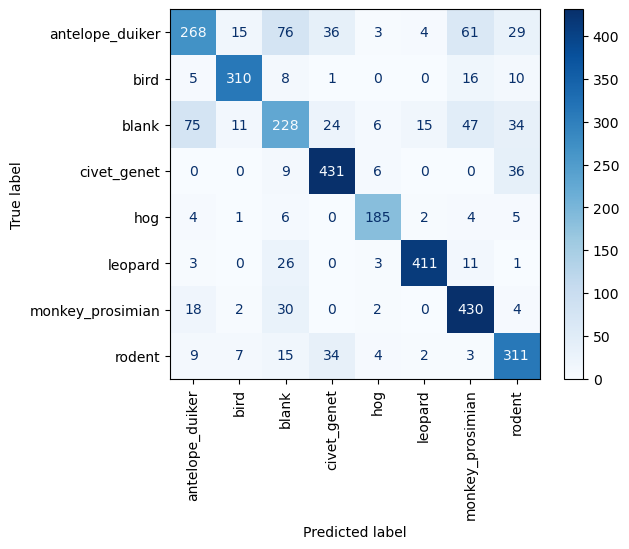

In [61]:
cm = confusion_matrix(targets, predictions.cpu())

disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=classes)

disp.plot(cmap=plt.cm.Blues, xticks_rotation="vertical")
plt.show();

# csv Id Mapping
Now we can use our model to complete the competition. They want our model's confidences for each of the 
8 classes on a test set. We don't know the answer here (it wouldn't be much of a competition if we did!). We'll need to run each image through our model.

They want the results saved as a csv file, with the columns labeled by the class, and the row index with a special ID. They've given us a file saying how these IDs map to image files. This will be easiest for us to save as a DataFrame.

First, we need to read in the IDs and filenames. All of the test data is in the data_multiclass/test directory, and this ID mapping is in the test_features.csv file.

# Read in the ID mapping csv file with pandas.

In [ ]:
import os
os.chdir("C:/Users/MonsuratAyinde/Desktop")


In [73]:
data_dir = "data_multiclass/"
test_dir = os.path.join(data_dir, "mydata")
id_file_location = os.path.join(test_dir, 'test_features.csv')
df_ids = pd.read_csv(id_file_location)
df_ids.head()

,id,filepath,site
0,ZJ016488,test_features/ZJ016488.jpg,S0082
1,ZJ016489,test_features/ZJ016489.jpg,S0040
2,ZJ016490,test_features/ZJ016490.jpg,S0040
3,ZJ016491,test_features/ZJ016491.jpg,S0041
4,ZJ016492,test_features/ZJ016492.jpg,S0040


In [74]:
df_ids.drop(columns="site")

,id,filepath
0,ZJ016488,test_features/ZJ016488.jpg
1,ZJ016489,test_features/ZJ016489.jpg
2,ZJ016490,test_features/ZJ016490.jpg
3,ZJ016491,test_features/ZJ016491.jpg
4,ZJ016492,test_features/ZJ016492.jpg
...,...,...
4459,ZJ020947,test_features/ZJ020947.jpg
4460,ZJ020948,test_features/ZJ020948.jpg
4461,ZJ020949,test_features/ZJ020949.jpg
4462,ZJ020950,test_features/ZJ020950.jpg


In [75]:
test_image_location = df_ids.iloc[0, 1]
test_image_location

'test_features/ZJ016488.jpg'

In [76]:
# Use PIL to open this image and assign it to test_image

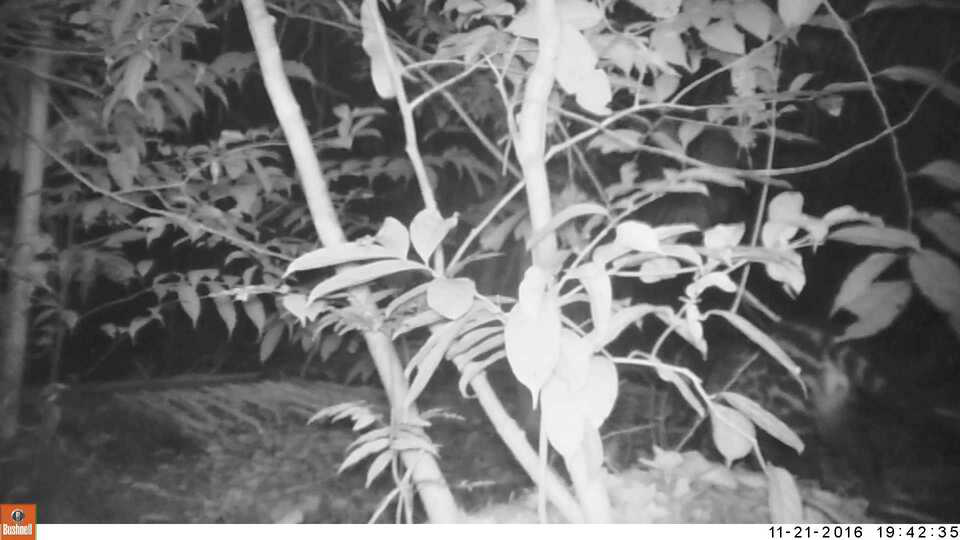

In [77]:
test_image_path = os.path.join(test_dir, test_image_location)
test_image = PIL.Image.open(test_image_path)
test_image

In [78]:
test_image_trans = transform_norm(test_image)
test_image_trans.shape

torch.Size([3, 224, 224])

Almost there. Our model is actually expecting a batch of these. Since we only have one, we'll need to change the tensor to a $1$ x $3$ x $224$ x $224$. We could do this with `reshape`, but it's easier to use `unsqueeze`. `unsqueeze` is meant for this exact problem. It adds an extra dimension with one element. We just specify _which_ extra dimension we want. In our case, we want the first dimension (i.e. `0`) to be the extra one.

In [79]:
test_unsqueeze = test_image_trans.unsqueeze(0)
test_unsqueeze.shape

torch.Size([1, 3, 224, 224])

In [80]:
test_image_cuda = test_unsqueeze.to(device)
test_out = model(test_image_cuda)
test_out

tensor([[ 3.4852, -6.4502,  2.8422,  2.7270, -8.8931, -4.6241, -1.8668,  2.8449]],
       grad_fn=<AddmmBackward0>)

That's the model's predictions, but it's not in the form we expected. We want a set of numbers between $0$ and $1$, that sum to $1$. What we're seeing is the raw output of the last layer. To convert this to the confidences, we need to run it through a `SoftMax`. This is very much like the logistic or sigmoid you've seen before, except that it works with many inputs. The `dim=1` tells it each row is one prediction.

In [81]:
test_softmax = torch.nn.functional.softmax(test_out, dim=1)
test_softmax

tensor([[3.9581e-01, 1.9170e-05, 2.0808e-01, 1.8544e-01, 1.6661e-06, 1.1903e-04,
         1.8757e-03, 2.0865e-01]], grad_fn=<SoftmaxBackward0>)

Now that we have our numbers, we need to convert to a DataFrame. The predictions are made in the same order as the classes in our dataset. We can't convert a tensor directly to a DataFrame, so we'll convert it to a list first. Then we can set the columns to our classes.

In [82]:
test_df = pd.DataFrame(test_softmax.tolist())
test_df.columns = dataset.classes

test_df

,antelope_duiker,bird,blank,civet_genet,hog,leopard,monkey_prosimian,rodent
0,0.395813,0.000019,0.208081,0.185442,0.000002,0.000119,0.001876,0.208649


# set the index to the ID.

In [83]:
image_id = df_ids.iloc[0, 0]
test_df.index = [image_id]

test_df

,antelope_duiker,bird,blank,civet_genet,hog,leopard,monkey_prosimian,rodent
ZJ016488,0.395813,0.000019,0.208081,0.185442,0.000002,0.000119,0.001876,0.208649


In [84]:
model.to(device)


def file_to_confidence(file_path, image_id):
    image = PIL.Image.open(file_path)
    transformed = transform_norm(image)
    unsqueezed = transformed.unsqueeze(0)
    image_cuda = unsqueezed.to(device)

    model.eval()
    with torch.no_grad():
        model_raw = model(image_cuda)
        confidence = torch.nn.functional.softmax(model_raw, dim=1)

    conf_df = pd.DataFrame(confidence.tolist())
    conf_df.columns = dataset.classes
    conf_df.index = [image_id]

    return conf_df

In [85]:
file_to_confidence(test_image_path, image_id)

,antelope_duiker,bird,blank,civet_genet,hog,leopard,monkey_prosimian,rodent
ZJ016488,0.395813,0.000019,0.208081,0.185442,0.000002,0.000119,0.001876,0.208649


In [86]:
file_to_confidence(test_image_path, image_id)

,antelope_duiker,bird,blank,civet_genet,hog,leopard,monkey_prosimian,rodent
ZJ016488,0.395813,0.000019,0.208081,0.185442,0.000002,0.000119,0.001876,0.208649


In [87]:
small_dfs = []

for row in df_ids.itertuples():
    image_id = row.id
    file_loc = row.filepath
    filepath = os.path.join(test_dir, file_loc)
    small_dfs.append(file_to_confidence(filepath, image_id))

confidence_df = pd.concat(small_dfs)


In [88]:
confidence_df.to_csv("submission.csv")

In [91]:
# os.makedirs("model1", exist_ok=True)

In [92]:
# torch.save(model, "model1/deepnet.pt")


In [93]:
os.makedirs("model2", exist_ok=True)

In [94]:
torch.save(model, "model2/deepnet.pt")
